In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2



In [23]:
#Load dataset to df
path = 'loans.csv'
df = pd.read_csv(path)

#Show the head of data set
df.head()

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
0,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
1,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
2,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
3,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
4,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


In [24]:
loans = df
X = loans.drop(['safe_loans'], axis=1)
Y = loans['safe_loans']
X_dict = X.to_dict(orient='records')
X_dict

[{'grade': 'C',
  'sub_grade': 'C4',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 1.0,
  'purpose': 'car',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 9.4,
  'total_rec_late_fee': 0.0},
 {'grade': 'F',
  'sub_grade': 'F2',
  'short_emp': 0,
  'emp_length_num': 5,
  'home_ownership': 'OWN',
  'dti': 5.55,
  'purpose': 'small_business',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 32.6,
  'total_rec_late_fee': 0.0},
 {'grade': 'B',
  'sub_grade': 'B5',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 18.08,
  'purpose': 'other',
  'term': ' 60 months',
  'last_delinq_none': 1,
  'last_major_derog_none': 1,
  'revol_util': 36.5,
  'total_rec_late_fee': 0.0},
 {'grade': 'C',
  'sub_grade': 'C1',
  'short_emp': 1,
  'emp_length_num': 1,
  'home_ownership': 'RENT',
  'dti': 10.08,
  'purpose': 'debt_consolidation',
  'term': ' 36 m

In [25]:
# Feature engineering
# For preprocessing, Impute missing values by mean for numeric variable and most frequency for catergory variable
# Encoding categorical variables using OneHotEncoder
# Separate categorical and numerical columns
categoric_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Handling missing values
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Applying OneHotEncoder to categorical features, imputing missing values, and scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('num_imputer', numeric_transformer, numerical_features),
        ('cat_imputer', categorical_transformer, categorical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_trans = preprocessor.fit_transform(X)
X_imputed = pd.DataFrame(X, columns=numeric_features.tolist() + categorical_features.tolist())
# Feature engineering
X_dict = X_imputed.to_dict(orient='records')
vec = DictVectorizer()
X_trans = vec.fit_transform(X_dict)

# Scaling the features
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_trans)

In [26]:
# Feature Selection
X_new = SelectKBest(chi2, k=20).fit_transform(X_scaled, Y)


In [27]:
# Addressing Class Imbalance using SMOTE
sm = SMOTE(random_state=1)
X_res, Y_res = sm.fit_resample(X_new, Y)

In [28]:
# Splitting training and test set again after resampling
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, random_state=1)


In [29]:
# Using Gradient Boosting for improved accuracy
gb_clf = GradientBoostingClassifier(random_state=1)


In [30]:
# Hyperparameter tuning with RandomizedSearchCV for Gradient Boosting
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
random_search = RandomizedSearchCV(gb_clf, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=1)
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=1, scoring='accuracy')

In [31]:
# Best estimator from RandomizedSearchCV
best_gb_clf = random_search.best_estimator_
accuracy = accuracy_score(Y_test, best_gb_clf.predict(X_test))
print('Accuracy of the optimized Gradient Boosting model: ', accuracy)

Accuracy of the optimized Gradient Boosting model:  0.6325884065416559


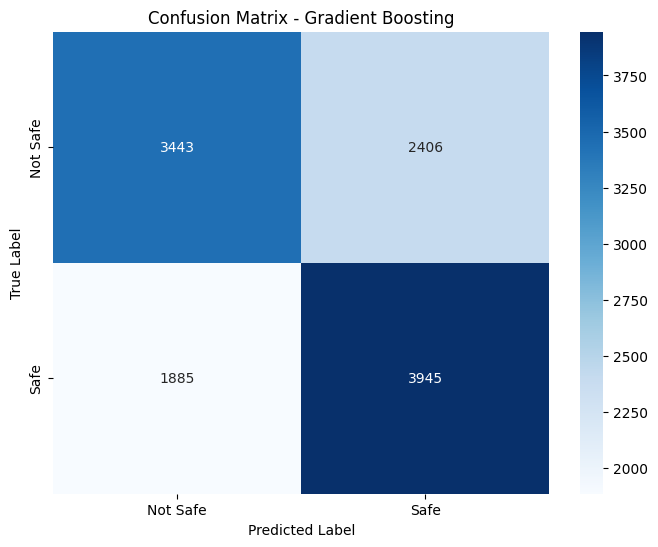

In [32]:
# Confusion Matrix for Gradient Boosting
conf_matrix = confusion_matrix(Y_test, best_gb_clf.predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Safe', 'Safe'], yticklabels=['Not Safe', 'Safe'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()


In [33]:
# Classification Report for Gradient Boosting
print('Classification Report:')
print(classification_report(Y_test, best_gb_clf.predict(X_test)))

Classification Report:
              precision    recall  f1-score   support

          -1       0.65      0.59      0.62      5849
           1       0.62      0.68      0.65      5830

    accuracy                           0.63     11679
   macro avg       0.63      0.63      0.63     11679
weighted avg       0.63      0.63      0.63     11679



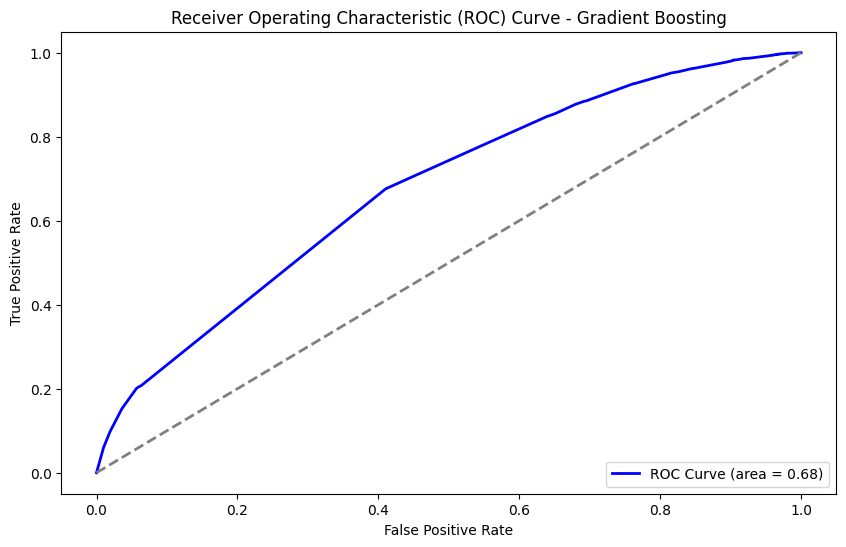

In [34]:
# ROC Curve for Gradient Boosting
fpr, tpr, _ = roc_curve(Y_test, best_gb_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()
